<a href="https://colab.research.google.com/github/DennisMYoung/Histopathologic_Cancer_Detection/blob/main/Histopathologic_Cancer_Detection_Kaggle_Sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

The objective of this project is to use CNNs to identify metastatic cancer in small image patches taken from larger digital pathology scans.

###ktrain

The python library 'ktrain' will be used in this project.  Ktrain is a low-code Python library that makes it very easy to train machine learning models.  

Examples, tutorials, and documentation can be found at the GitHub repository below.

https://github.com/amaiya/ktrain

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ktrain import vision as vis

##Datasets



##Data

Labels are provided for each patch in the training data folder.  The 'id' corresponds to the file name of the image. The 'label' is used for the binary classification.  A label of 1 indicates that there is at least one pixel of cancer the center 32x32px region of a patch.

Note, cancer in the outer region of the patch does not lead to a value of 1.  This is to allow for padding.  

It is stated in the data description that all duplicates have been removed.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Cancer/Data/train_labels.csv') # Assuming you stored data under 'MyDrive'
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


##EDA

Our training data has ~130K scans that do not show metastatic cancer and ~89K scans that do show metastatic cancer.  While this data is not perfectly balanced, it is likely balanced enough to run the model without balancing the data.

label
0    130908
1     89117
Name: count, dtype: int64


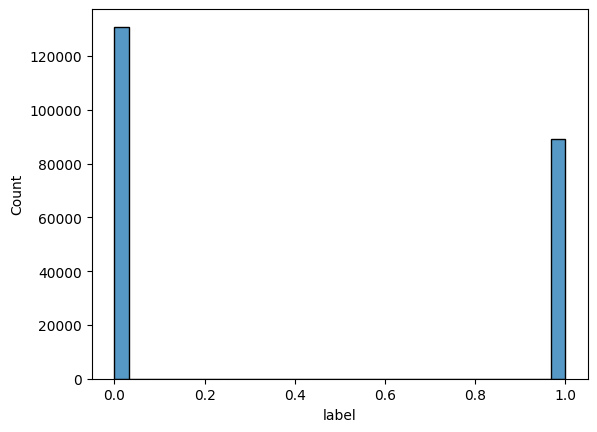

In [ ]:
sns.histplot(labels['label'])
print(labels['label'].value_counts())

In [ ]:
data_dir = '/content/drive/MyDrive/Cancer/Data'
!!head {data_dir}/train_labels.csv

['id,label',
 'f38a6374c348f90b587e046aac6079959adf3835,0',
 'c18f2d887b7ae4f6742ee445113fa1aef383ed77,1',
 '755db6279dae599ebb4d39a9123cce439965282d,0',
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0',
 '068aba587a4950175d04c680d38943fd488d6a9d,0',
 'acfe80838488fae3c89bd21ade75be5c34e66be7,0',
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1',
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f,1',
 '559e55a64c9ba828f700e948f6886f4cea919261,0']

One of the biggest challenges that I have had with this project is that it takes a very long time to train the models.  In order to experiment, I limited the image sample to 20K and decided to balance the data since the data is already subsetted.

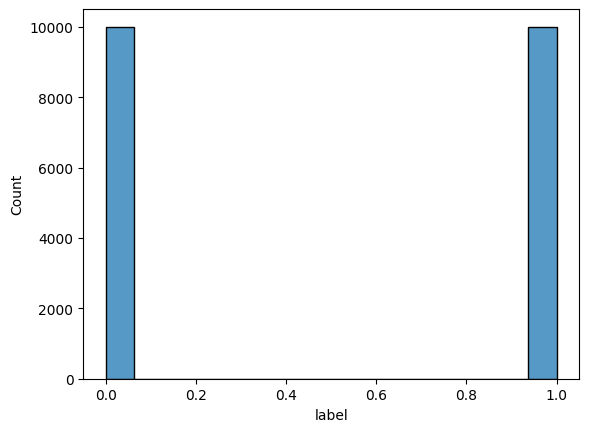

In [ ]:
sample_size = 20000
## Balanced the data
pos_rate = .5
pos = round(sample_size*pos_rate)
neg = sample_size - pos

small_labels_pos= labels[labels['label']==1].sample(n=pos)
small_labels_neg= labels[labels['label']==0].sample(n=neg)
small_labels = pd.concat([small_labels_pos, small_labels_neg])
sns.histplot(small_labels['label'])
small_labels.to_csv(data_dir+'/small_labels.csv', index=False)

The step below added the ".tif" suffix to the 'id' value in the labels document.

In [ ]:
orig_dat = data_dir+'/small_labels.csv'
add_suffix_dat = data_dir+'/small_train_labels_add_suffix.csv'
new_labels = vis.preprocess_csv(orig_dat,
                           add_suffix_dat,
                           x_col='id', y_col='label', suffix='.tif')

In [ ]:
!!head {data_dir}/train_labels_add_suffix.csv

['id,0,1',
 'f38a6374c348f90b587e046aac6079959adf3835.tif,1,0',
 'c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,0,1',
 '755db6279dae599ebb4d39a9123cce439965282d.tif,1,0',
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,1,0',
 '068aba587a4950175d04c680d38943fd488d6a9d.tif,1,0',
 'acfe80838488fae3c89bd21ade75be5c34e66be7.tif,1,0',
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif,0,1',
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif,0,1',
 '559e55a64c9ba828f700e948f6886f4cea919261.tif,1,0']

The ktrain python library makes it very easy to attach labels to the images we want to train on.  In this step, we can also augment the images.  For example, we can flip the images or rotate them to add to our training set.  However, we already have an issue with training time.  So, I am not applying any data augmentation to the prepossing step below.

In [ ]:
train_data_le, val_data_le, preproc_le = vis.images_from_csv(
                          add_suffix_dat,
                         'id',
                          directory=data_dir+'/train',
                          val_filepath = None,
                          label_columns = new_labels)

['0', '1']
       0  1
10055  1  0
8544   0  1
8231   0  1
16906  1  0
18264  1  0
['0', '1']
       0  1
10497  1  0
4802   0  1
17223  1  0
13059  1  0
2973   0  1
Found 17998 validated image filenames.


/usr/local/lib/python3.11/dist-packages/tf_keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 2000 validated image filenames.


Below are a list of pre-training models available in ktrain.  There is also the ability run customized keras models in ktrain.  However, the runtime of my custom models was too long, even when running simple models.  The pre-trained models have had better performance and quicker training times.

I know from previous research that resnet models perform well on cancer dectection models (see: https://www.sciencedirect.com/science/article/pii/S2772442524000182).  

I will first try with the 'default_cnn', which is described as a "LeNet-Like" CNN.  However, the architecture is very similar to a typically CNN architecture.

In [ ]:
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

In [ ]:
model_le = vis.image_classifier('default_cnn', train_data_le, val_data_le)

Is Multi-Label? False
Is Regression? False
default_cnn model created.


#Architecture

Below is the summary of the 'default_cnn' model.  It is described as a "LeNet-like" CNN.  However, the model has a typical CNN architecture.  There are two convultion layers with a max pool layer and dropout layer to avoid over-fitting.  This is repeated three times.  It also includes two dense lense layers and batch normalization in the classifier.  

While not an super advanced CNN, this is similar to what I was attempting with my custom CNN, but it trains much faster.

In [ ]:
model_le.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 64)      36928     
                                                        

In [ ]:
learner_le = ktrain.get_learner(model_le, train_data=train_data_le, val_data=val_data_le,
                                use_multiprocessing=False, batch_size=128, workers = 8)

This next step will train the model with different learning rates to help determine the max learning rate for our model.

In [ ]:
learner_le.reset_weights(verbose=0)
learner_le.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
140/140 [==============================] - 413s 3s/step - loss: 1.1135 - accuracy: 0.5129
Epoch 2/5
140/140 [==============================] - 34s 233ms/step - loss: 0.7875 - accuracy: 0.6139
Epoch 3/5
140/140 [==============================] - 34s 229ms/step - loss: 0.5396 - accuracy: 0.7533
Epoch 4/5
140/140 [==============================] - 34s 230ms/step - loss: 0.6934 - accuracy: 0.5875
Epoch 5/5
140/140 [==============================] - 14s 84ms/step - loss: 9.8452 - accuracy: 0.5242


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


From the chart below, it looks like the ideal learning rate is between 10^-2 and 10^-3.  I will run with 10^-2 for a quicker runtime since the two learning rates have similar performance.

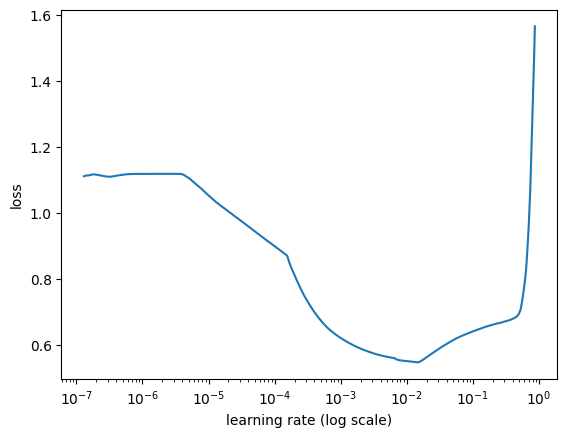

In [ ]:
learner_le.lr_plot()

The autofit method in ktrain employs a triangular learning rate schedule and uses the supplied learning rate as the maximum learning rate.  It includes the 'early_stopping' aurgument, which stops the training when the epoch fails to produce a lower 'val_loss'.

The fit_onecycle method is a nice alternative to the autofit method, that sometimes produces different results.  However, it does not have the 'early_stopping' option.

In [ ]:
history_le = learner_le.autofit(
    .001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/10
141/141 [==============================] - 89s 616ms/step - loss: 0.5601 - accuracy: 0.7281 - val_loss: 0.5491 - val_accuracy: 0.7795
Epoch 2/10
141/141 [==============================] - 45s 308ms/step - loss: 0.4758 - accuracy: 0.7836 - val_loss: 1.2105 - val_accuracy: 0.5980
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


#Evaluation

The accuracy of 0.78 is significantly higher than 0.5. This indicates that the model is learning.  Since the data is balanced, accuracy is good measure of model performance.

The area under the ROC curve on the test data had a private score of 0.7112 and public score of 0.7851.  The large difference between the private score and the public score indicates over-fitting.

In [ ]:
validation = learner_le.validate(val_data=val_data_le, print_report=True)

63/63 [==============================] - 9s 135ms/step
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1028
           1       0.73      0.86      0.79       972

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



Below are the two images with the highest loss.  In otherwords they were the probability was farthest from the actual result. Both images were predicted to have cancer but did not.=

63/63 [==============================] - 8s 121ms/step


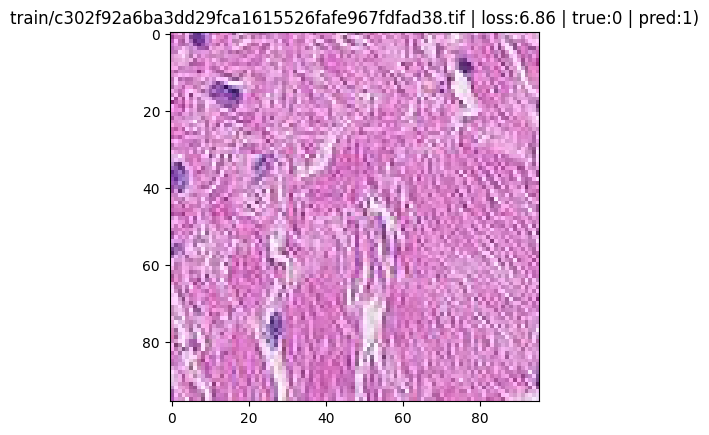

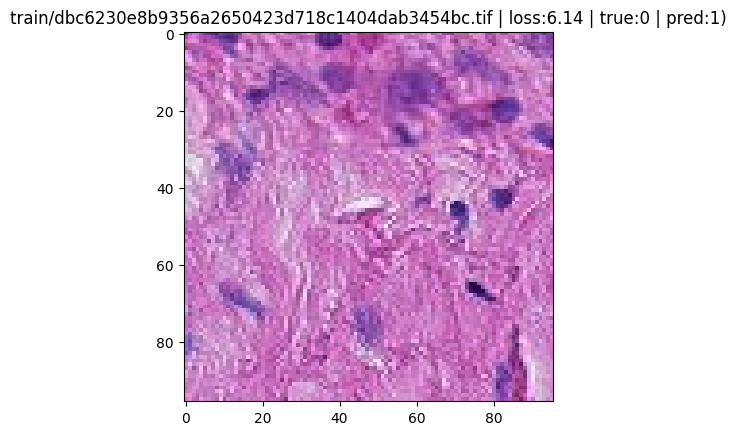

In [ ]:
learner_le.view_top_losses(n=2, preproc=preproc_le)

#Prediction

There are ~57K images in our test folder.  I will now use the model to predict the results of each image.

In [ ]:
import glob

directory_path = '/content/drive/MyDrive/Cancer/Data/test'
files = glob.glob(f"{directory_path}/*")

files[0:5]

['/content/drive/MyDrive/Cancer/Data/test/fb346cfbd1cbfe784b25a6e57f7a7d875e919f17.tif',
 '/content/drive/MyDrive/Cancer/Data/test/fb92b3c46edd93be190e8f9780d90dd9c0d9be69.tif',
 '/content/drive/MyDrive/Cancer/Data/test/fb636fce90ddcc0c898a0621249d5ee9979cb96c.tif',
 '/content/drive/MyDrive/Cancer/Data/test/fbbf50468b0b263316b29cde53f94638e9bfed97.tif',
 '/content/drive/MyDrive/Cancer/Data/test/fb955a116b9b64cf5b382892ecdc7aeb1a0b81a4.tif']

In [ ]:
len(files)

57458

In [ ]:
predictor_le = ktrain.get_predictor(learner_le.model, preproc_le)

In [ ]:
pred_le = predictor_le.predict_folder('/content/drive/MyDrive/Cancer/Data/test')

Found 57458 images belonging to 1 classes.


In [ ]:
pred_le[:5]

[('test/00006537328c33e284c973d7b39d340809f7271b.tif', '1'),
 ('test/0000ec92553fda4ce39889f9226ace43cae3364e.tif', '1'),
 ('test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', '1'),
 ('test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', '0'),
 ('test/000270442cc15af719583a8172c87cd2bd9c7746.tif', '0')]

In [ ]:
pred_le_df = pd.DataFrame(pred_le, columns=['id', 'label'])
pred_le_df['id'] = pred_le_df['id'].str.replace('.tif', '')
pred_le_df['id'] = pred_le_df['id'].str.replace('test/', '')
pred_le_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [ ]:
pred_le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  object
dtypes: object(2)
memory usage: 897.9+ KB


<Axes: xlabel='label', ylabel='Count'>

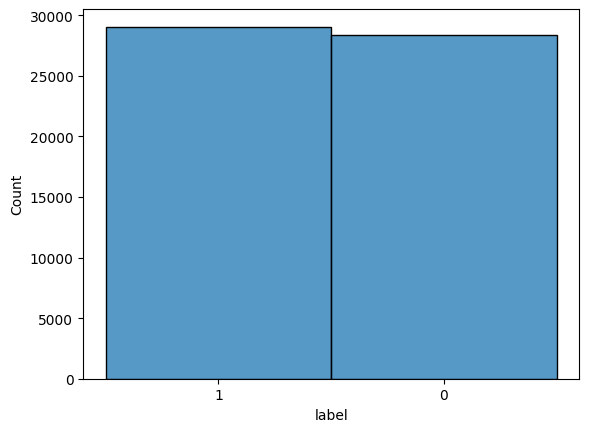

In [ ]:
sns.histplot(pred_le_df['label'])

In [ ]:
pred_le_df['label'] = pred_le_df['label'].astype(int)

In [ ]:
pred_le_df.to_csv('/content/drive/MyDrive/Cancer/Data/submission_le.csv', index=False)

##Resnet Model

The default cnn was better than random at identifying cancer in the images.  However, the results were somewhat disappointing.  Let's run the same model with resnet architecture.  Resnet models use residual block and skip networks to train a many layer in a more effecient manner.

In [ ]:
train_data_resnet, val_data_resnet, preproc_resnet = vis.images_from_csv(
                          add_suffix_dat,
                         'id',
                          directory=data_dir+'/train',
                          val_filepath = None,
                          label_columns = new_labels)

['0', '1']
       0  1
4976   0  1
3499   0  1
10985  1  0
2884   0  1
2303   0  1
['0', '1']
       0  1
9102   0  1
9912   0  1
6764   0  1
7314   0  1
13937  1  0
Found 18000 validated image filenames.
Found 2000 validated image filenames.


In [ ]:
model_resnet = vis.image_classifier('resnet50', train_data_resnet, val_data_resnet)

Is Multi-Label? False
Is Regression? False
resnet50 model created.


In [ ]:
learner_resnet = ktrain.get_learner(model_resnet, train_data=train_data_resnet, val_data=val_data_resnet,
                                use_multiprocessing=False, batch_size=64, workers = 8)

In [ ]:
learner_resnet.reset_weights(verbose=0)
learner_resnet.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
281/281 [==============================] - 39s 122ms/step - loss: 6.6847 - accuracy: 0.4920
Epoch 2/5
281/281 [==============================] - 34s 118ms/step - loss: 6.1394 - accuracy: 0.5482
Epoch 3/5
281/281 [==============================] - 20s 67ms/step - loss: 35.3567 - accuracy: 0.5704


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


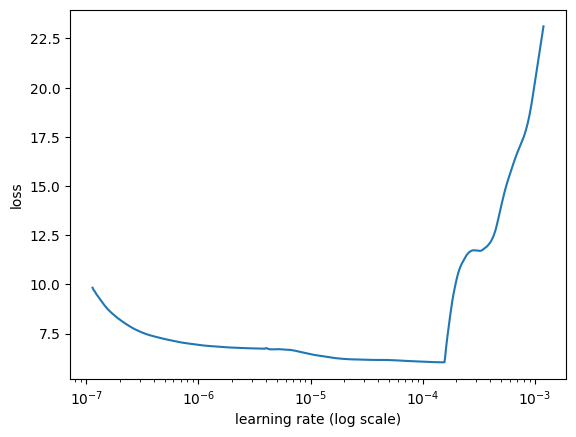

In [ ]:
learner_resnet.lr_plot()

After running with multiple learning rates, it appears that 10^-4 is good choice for the max learning rate.

In [ ]:
learner_resnet.reset_weights(verbose=0)
history_resnet = learner_resnet.autofit(
    .0001,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
282/282 [==============================] - 47s 159ms/step - loss: 6.5429 - accuracy: 0.5974 - val_loss: 1.6215 - val_accuracy: 0.7770
Epoch 2/10
282/282 [==============================] - 40s 138ms/step - loss: 4.6669 - accuracy: 0.6625 - val_loss: 1.8311 - val_accuracy: 0.7785
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


#Evaluation

Since the data is balanced, 'accuracy' is good indicator of model performance.  Since the score of 0.78 is signicantly higher than an accuracy of 0.5, there are indications that the model is learning.  The results are very similar to the default CNN.

The area under the ROC curve on the test data had a private score of 0.7251 and public score of 0.7694.  The large difference between the private score and the public score indicates over-fitting.

In [ ]:
learner_resnet.validate(val_data=val_data_resnet, print_report=True)

63/63 [==============================] - 11s 156ms/step
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       995
           1       0.76      0.80      0.78      1005

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



array([[745, 250],
       [196, 809]])

In [ ]:
predictor_resnet = ktrain.get_predictor(learner_resnet.model, preproc_resnet)

In [ ]:
pred_resnet = predictor_resnet.predict_folder('/content/drive/MyDrive/Cancer/Data/test')

Found 57458 images belonging to 1 classes.


In [ ]:
pred_resnet_df = pd.DataFrame(pred_resnet, columns=['id', 'label'])
pred_resnet_df['id'] = pred_resnet_df['id'].str.replace('.tif', '')
pred_resnet_df['id'] = pred_resnet_df['id'].str.replace('test/', '')
pred_resnet_df['label'] = pred_resnet_df['label'].astype(int)
pred_resnet_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [ ]:
pred_resnet_df.to_csv('/content/drive/MyDrive/Cancer/Data/submission_resnet.csv', index=False)

##Final Model

The results of the default cnn and the resnet model were similar.  In both models, there were signs of over-fitting.  Let's run the default CNN, with all available training data to avoid over-fitting.  We will also increase our training data by flipping the data, both horizontally and vertically.

In [ ]:
orig_dat_all = data_dir+'/train_labels.csv'
add_suffix_dat_all = data_dir+'/train_labels_add_suffix.csv'
new_labels_all = vis.preprocess_csv(orig_dat_all,
                           add_suffix_dat_all,
                           x_col='id', y_col='label', suffix='.tif')

In [ ]:
data_aug = vis.get_data_aug(horizontal_flip=True, vertical_flip=True)

In [ ]:
train_data_all, val_data_all, preproc = vis.images_from_csv(
                          add_suffix_dat_all,
                         'id',
                          directory=data_dir+'/train',
                          val_filepath = None,
                          data_aug = data_aug,
                          label_columns = new_labels_all)

['0', '1']
        0  1
206887  0  1
216310  1  0
67082   1  0
199294  0  1
181497  1  0
['0', '1']
        0  1
130640  0  1
177032  1  0
56417   1  0
181385  1  0
44475   1  0
Found 220025 images belonging to 1 classes.
Found 198022 validated image filenames.
Found 22003 validated image filenames.


In [ ]:
model_all = vis.image_classifier('default_cnn', train_data_all, val_data_all)

Is Multi-Label? False
Is Regression? False
default_cnn model created.


In [ ]:
learner_all = ktrain.get_learner(model_all, train_data=train_data_all, val_data=val_data_all,
                                use_multiprocessing=False, batch_size=128, workers = 8)

In [ ]:
learner_all.reset_weights(verbose=0)
learner_all.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
1547/1547 [==============================] - 5331s 3s/step - loss: 0.7181 - accuracy: 0.6907
Epoch 2/5
1547/1547 [==============================] - 628s 404ms/step - loss: 0.5100 - accuracy: 0.7637
Epoch 3/5
1547/1547 [==============================] - 623s 401ms/step - loss: 0.4011 - accuracy: 0.8270
Epoch 4/5
1547/1547 [==============================] - 621s 400ms/step - loss: 0.4371 - accuracy: 0.8267
Epoch 5/5
1547/1547 [==============================] - 26s 15ms/step - loss: 2.9380 - accuracy: 0.6882


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


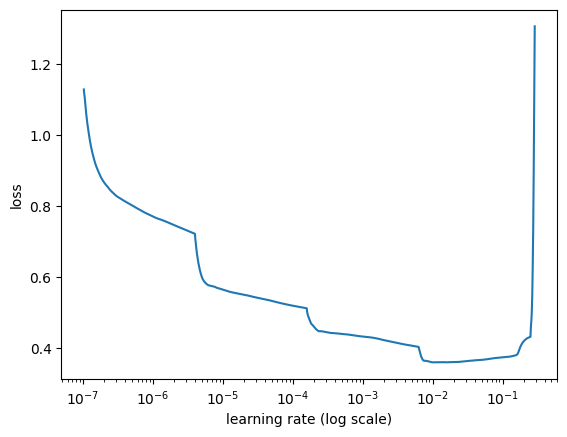

In [ ]:
learner_all.lr_plot()

Originally ran with a learning rate of .1 because of the chart above.  However, it stopped after the first epoch.  So, ran again with a learning rate of 0.01.

In [ ]:
learner_all.reset_weights(verbose=0)
history_all = learner_all.autofit(
    .01,
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/10
1548/1548 [==============================] - 685s 441ms/step - loss: 0.3987 - accuracy: 0.8283 - val_loss: 0.3249 - val_accuracy: 0.8637
Epoch 2/10
1548/1548 [==============================] - 681s 438ms/step - loss: 0.3385 - accuracy: 0.8567 - val_loss: 0.2996 - val_accuracy: 0.8709
Epoch 3/10
1548/1548 [==============================] - 688s 443ms/step - loss: 0.3264 - accuracy: 0.8622 - val_loss: 0.2876 - val_accuracy: 0.8804
Epoch 4/10
1548/1548 [==============================] - 694s 446ms/step - loss: 0.3137 - accuracy: 0.8686 - val_loss: 0.2666 - val_accuracy: 0.8905
Epoch 5/10
1548/1548 [==============================] - 685s 441ms/step - loss: 0.3005 - accuracy: 0.8747 - val_loss: 0.2799 - val_accuracy: 0.8988
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 4.
Weights from best epoch have been loaded into model.


#Evaluation

This model has an F1-score of 0.86 on the postitive cases.  This is a significant improvement on the original version that was trained on a smaller sample of data.  When trained on the subset of data, the F1-score on the positive cases was 0.79.  The f1-score is higher on the negative cases, indicating that it might benefit from balancing training data.

The area under the ROC curve on the test data had a private score of 0.7947 and public score of 0.8234.  This is a considerable improvement on earlier submissions but near the bottom of the leaderboard in the competition.

In [ ]:
learner_all.validate(val_data=val_data_all, print_report=True)

688/688 [==============================] - 102s 149ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     13017
           1       0.88      0.84      0.86      8986

    accuracy                           0.89     22003
   macro avg       0.89      0.88      0.89     22003
weighted avg       0.89      0.89      0.89     22003



array([[12004,  1013],
       [ 1397,  7589]])

Below are the two cases with the largest loss.  Both are predicted as not cancer but actually have tumor cells in the central pixels.  As a human, I also would have missed the tumor pixels.

688/688 [==============================] - 100s 145ms/step


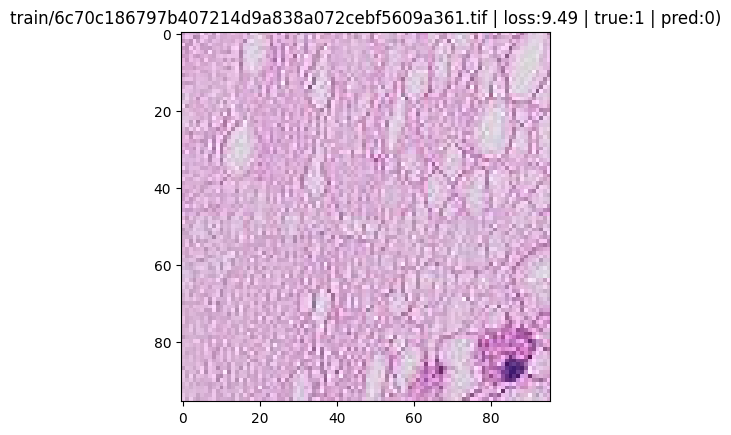

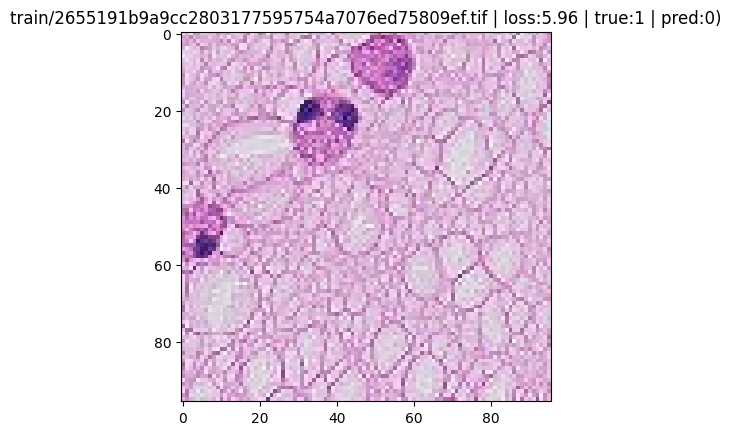

In [ ]:
learner_all.view_top_losses(n=2, preproc=preproc)

In [ ]:
predictor_all = ktrain.get_predictor(learner_all.model, preproc)

In [ ]:
pred_all = predictor_all.predict_folder('/content/drive/MyDrive/Cancer/Data/test')

Found 57458 images belonging to 1 classes.


In [ ]:
pred_all_df = pd.DataFrame(pred_all, columns=['id', 'label'])
pred_all_df['id'] = pred_all_df['id'].str.replace('.tif', '')
pred_all_df['id'] = pred_all_df['id'].str.replace('test/', '')
pred_all_df['label'] = pred_all_df['label'].astype(int)

In [ ]:
pred_all_df.to_csv('/content/drive/MyDrive/Cancer/Data/submission_le_all.csv', index=False)

##Conclusion

The default CNN in ktrain, which has a standard CNN architecture, provided decent results, when training on all available training data, with some data augmentation.  The default CNN model and the resnet model both showed that they were working on limited data but show signs of over-fitting.  The results from the resnet model were very similar to the results from the default CNN.  However, the default CNN has a much more basic architecture.  So, I decided to re-run the default CNN with all available training data, not just the sample of 20K images.  In addition, I added some basic data augmentation, flipping the image both horizontally and vertically.  The results were much improved.  However, they were substandard relative to the other participants in the Kaggle competition.  

Eventually, I would like to try this version of the model without early stopping.  In addition, I would like to experiment with additional data augmentation methods, like rotation.  

The primary issue that I ran into was long run-times.  The pre-training models performed better and faster runtimes than my initial attempts with custom models.  There are other pre-trained models available in ktrain that I would also like to experiment with.  Unfortunately, there is a limit on available time for experimentation.